In [1]:
from google.oauth2.service_account import Credentials
import gspread
import pandas as pd


In [58]:

creds = Credentials.from_service_account_file(
    "service_account.json",
    scopes=["https://www.googleapis.com/auth/spreadsheets.readonly"]
)

gc = gspread.authorize(creds)
sheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/19xtFu9__d6FSny_PP_1AFINLCDfYoKaX9TIOmYVsmTs/edit")
worksheet = sheet.sheet1
data = worksheet.get_all_values()

# --- Skip first row and assign your own headers ---
df = pd.DataFrame(data[1:], columns=["timestamp", "uptime", "value", "2nd_value", "3rd_value"])
df = df.iloc[:, :3]
print(df.head())

             timestamp               uptime                            value
0  10/17/2025 21:14:48  0:2:3:4:5:11:18:19:  89:224:268:217:232:246:229:249:
1  10/17/2025 21:14:59               29:32:                         242:261:
2  10/17/2025 21:15:09                  36:                             242:
3  10/17/2025 21:15:21                  46:                             240:
4  10/17/2025 21:15:32            57:63:64:                     245:275:238:


In [73]:
# Expand each row into multiple rows
rows = []
import numpy as np
for n, row in df.iterrows():
    # uptimes = [u for u in row["uptime"].split(":") if u != '']
    values = [v for v in row["value"].split(":") if v != ''] 

    # # Match pairs (uptime, value)
    # for u, v in zip(uptimes, values):
    #     try:
    #         rows.append({
    #             "uptime": int(u),
    #             "value": int(v)
    #         })
    #     except :
    #         print(f"Skipping invalid pair: uptime={u}, value={v} in row {n}")
    try:
        values_np = np.array(values, dtype=int)
        suitable_value = values_np[np.abs(values_np - values_np.mean()).argmin()]
        rows.append({
            "timestamp": row["timestamp"],
            "value": int(suitable_value)
        })
    except :
        print(f"Skipping invalid in row {n}")
expanded_df = pd.DataFrame(rows)
print(expanded_df.head())


Skipping invalid in row 3146
             timestamp  value
0  10/17/2025 21:14:48    217
1  10/17/2025 21:14:59    242
2  10/17/2025 21:15:09    242
3  10/17/2025 21:15:21    240
4  10/17/2025 21:15:32    245


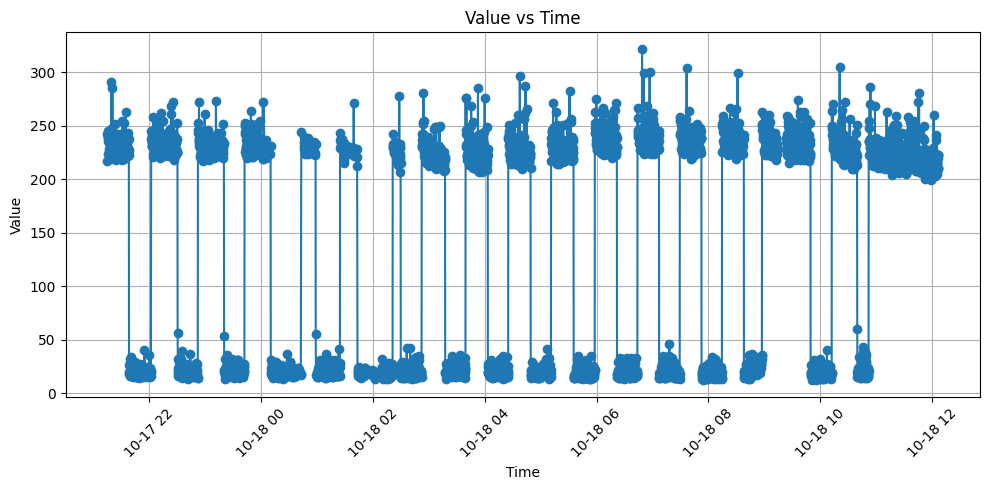

In [74]:
import matplotlib.pyplot as plt
# Convert timestamp column to datetime
expanded_df["timestamp"] = pd.to_datetime(expanded_df["timestamp"])

# Plot value vs time
plt.figure(figsize=(10, 5))
plt.plot(expanded_df["timestamp"], expanded_df["value"], marker='o', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Value vs Time")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [75]:
# Determine AC state
expanded_df["AC_ON"] = expanded_df["value"] > 150

# Compute time difference between consecutive samples
expanded_df["time_diff"] = expanded_df["timestamp"].diff().dt.total_seconds().fillna(0)

# Compute total ON and OFF time in seconds
total_on_seconds = expanded_df.loc[expanded_df["AC_ON"], "time_diff"].sum()
total_off_seconds = expanded_df.loc[~expanded_df["AC_ON"], "time_diff"].sum()

# Convert to hours
total_on_hours = total_on_seconds / 3600
total_off_hours = total_off_seconds / 3600

print(f"Total ON time: {total_on_hours:.4f} hours")
print(f"Total OFF time: {total_off_hours:.4f} hours")

Total ON time: 8.2733 hours
Total OFF time: 6.5967 hours
